In [2]:
import pandas as pd
import numpy as np
from joblib import Parallel, delayed
from sklearn.linear_model import ElasticNetCV,Ridge
from dateutil.relativedelta import relativedelta
from talib import *
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from statsmodels.tools.tools import add_constant
import os
import matplotlib.pyplot as plt
os.environ["OMP_NUM_THREADS"] = "1" # export OMP_NUM_THREADS=1
os.environ["OPENBLAS_NUM_THREADS"] = "1" # export OPENBLAS_NUM_THREADS=1
os.environ["MKL_NUM_THREADS"] = "1" # export MKL_NUM_THREADS=1
os.environ["VECLIB_MAXIMUM_THREADS"] = "1" # export VECLIB_MAXIMUM_THREADS=1
os.environ["NUMEXPR_NUM_THREADS"] = "1" # export NUMEXPR_NUM_THREADS=1

In [3]:
def relevance(X,normalization=True):
    X = pd.DataFrame(X)
    X_valid = X.dropna()
    if normalization:
        scaler = StandardScaler()
        XX = pd.DataFrame(scaler.fit_transform(X),index=X.index,columns=X.columns)
    else:
        X_mean = X_valid.mean()
        XX = X-X_mean.values[None,:]
    try:
        return pd.Series(np.array(np.matrix(XX.values) @ np.linalg.inv(np.matrix(XX.values).T @ np.matrix(XX.values)) @ np.matrix(XX.iloc[-1].values).T).ravel(), index = X_valid.index, name='relevance').reindex(index=X.index)
    except:
        return pd.Series(dtype=np.float64)
    
def rollingRelevance(df,window,min_period=252,normalization=True):
    if window < 1:
        return Parallel(n_jobs=-1,verbose=0)(delayed(relevance)(df.iloc[:i],normalization) for i in range(min_period,len(df)+1))
    else:
        return Parallel(n_jobs=-1,verbose=0)(delayed(relevance)(df.iloc[(i-window):i],normalization) for i in range(window,len(df)+1))

def RfilteredPred(Y,X,rel,normalization=True,fixed=False,polynomial=False):
    if (rel>0).sum()<1:
        if len(Y.shape)==1:
            return [np.nan]
        else:
            return [np.nan]*Y.shape[1]
    Y=pd.DataFrame(Y[rel>0].dropna())
    X=pd.DataFrame(X.loc[Y.index]).values
    Y=Y.values
    if normalization:
        scalerX = StandardScaler()
        scalerY = StandardScaler()
        X = scalerX.fit_transform(X)
        Y = scalerY.fit_transform(Y)
    if polynomial:
        poly = PolynomialFeatures(7, include_bias=False)
        X = poly.fit_transform(X)
    if not normalization and not fixed:
        X = add_constant(X)
    try:
        # res = np.array(np.matrix(X[-1]) @ np.linalg.inv(np.matrix(X).T @ np.matrix(X)) @ np.matrix(X).T @ np.matrix(Y))
        if Y.shape[1] == 1:
            ml = Ridge(alpha=1.0, fit_intercept=False)
            ml.fit(X, Y.ravel())
        res = ml.predict(X[-1][None,:])
        if normalization:
            res = scalerY.inverse_transform(res)
        return res.ravel().tolist()
    except:
        if len(Y.shape)==1:
            return [np.nan]
        else:
            return [np.nan]*Y.shape[1]

def rollingRfilteredPred(Y,X,window,min_period=252,normalization=True,fixed=False,polynomial=False):
    relevances = rollingRelevance(X,window,min_period,normalization)
    if window<1:
        res = [RfilteredPred(Y.iloc[:i],X.iloc[:i],relevances[i-min_period],normalization,fixed,polynomial) for i in range(min_period,len(Y)+1)]
        indexes = Y.index[(min_period-1):]
    else:
        res = [RfilteredPred(Y.iloc[(i-window):i],X.iloc[(i-window):i],relevances[i-window],normalization,fixed,polynomial) for i in range(window,len(Y)+1)] 
        indexes = Y.index[(window-1):]
    if len(Y.shape) == 1:
        return pd.DataFrame(np.array(res),index=indexes,columns=[Y.name]).reindex(index=Y.index)
    else:
        return pd.DataFrame(np.array(res),index=indexes,columns=Y.columns).reindex(index=Y.index)

def Pred(Y,X,normalization=True,fixed=False):
    Y=pd.DataFrame(Y.dropna())
    X=pd.DataFrame(X.loc[Y.index]).values
    Y=Y.values
    if normalization:
        scalerX = StandardScaler()
        scalerY = StandardScaler()
        X = scalerX.fit_transform(X)
        Y = scalerY.fit_transform(Y)
    if not normalization and not fixed:
        X = add_constant(X)
    try:
        if Y.shape[1] == 1:
            ml = Ridge(alpha=1.0, fit_intercept=False)
            ml.fit(X, Y.ravel())
        res = ml.predict(X[-1][None,:])
        if normalization:
            res = scalerY.inverse_transform(res)
        return res.ravel().tolist()
    except:
        if len(Y.shape)==1:
            return [np.nan]
        else:
            return [np.nan]*Y.shape[1]

def rollingPred(Y,X,window,min_period=252,normalization=True,fixed=False):
    if window<1:
        res = [Pred(Y.iloc[:i],X.iloc[:i],normalization,fixed) for i in range(min_period,len(Y)+1)]
        indexes = Y.index[(min_period-1):]
    else:
        res = [Pred(Y.iloc[(i-window):i],X.iloc[(i-window):i],normalization,fixed) for i in range(window,len(Y)+1)]
        indexes = Y.index[(window-1):]
    if len(Y.shape) == 1:
        return pd.DataFrame(np.array(res),index=indexes,columns=[Y.name]).reindex(index=Y.index)
    else:
        return pd.DataFrame(np.array(res),index=indexes,columns=Y.columns).reindex(index=Y.index)

def CEnet(Y,preds,normalization=True,fixed=False):
    data = pd.concat([pd.DataFrame(Y),preds],axis=1).dropna()
    Y = pd.DataFrame(data.iloc[:,0])
    preds = data.iloc[:,1:]
    if normalization:
        scalerX = StandardScaler()
        scalerY = StandardScaler()
        X = scalerX.fit_transform(preds)
        Y = scalerY.fit_transform(Y)
        fit_intercept = False
    elif fixed:
        X = preds.values
        Y = Y.values
        fit_intercept = False
    else:
        X = preds.values
        Y = Y.values
        fit_intercept = True
    Y = Y.ravel()
    model = ElasticNetCV(fit_intercept=fit_intercept,n_jobs=-1,max_iter=10000)
    model.fit(X,Y)
    return model, list(preds.columns[model.coef_!=0])

def walkforward(Y,X,categories,date_start,window,advance,lookback,min_period=252,normalization=True,fixed=False):
    print('----------Calculating Predictions-------------')
    preds = pd.concat(Parallel(n_jobs=-1,verbose=5)(delayed(rollingRfilteredPred)(Y,X[cate],window,min_period,normalization,fixed,False) for cate in categories),axis=1)
    preds.columns = ['stockIndex','treasury','commPrice','transportFeeIndex','commRefer','complex']
    date_s = date_start
    models = []
    factors_list = []
    res = []
    while date_s<Y.index[-1]:
        training_start = date_s+relativedelta(months=-lookback)
        training_end = date_s
        print('train period: ', f'{date_s+relativedelta(months=-lookback)}---{date_s}')
        print('test period: ', f'{date_s}---{date_s+relativedelta(months=+advance)}')
        model, factor = CEnet(Y.loc[(Y.index>=training_start)&((Y.index<training_end))],preds.loc[(preds.index>=training_start)&((preds.index<training_end))],False,True)
        # print(factors)
        factors_list.append(factor)
        models.append(model)
        test_index = preds.loc[(preds.index>=date_s)&(preds.index<date_s+relativedelta(months=+advance))].index
        valid_index = preds.loc[(preds.index>=date_s)&(preds.index<date_s+relativedelta(months=+advance))].dropna().index
        # score = pd.concat([pd.Series(preds.loc[(preds.index>=date_s)&(preds.index<date_s+relativedelta(months=+advance)),factors_list[i]].mean(axis=1),index=test_index) for i,model in enumerate(models)],axis=1).mean(axis=1)
        score = pd.concat([pd.Series(model.predict(preds.loc[(preds.index>=date_s)&(preds.index<date_s+relativedelta(months=+advance))].dropna()),index=valid_index).reindex(index=test_index) for i,model in enumerate(models)],axis=1).mean(axis=1)
        res.append(score)
        date_s = date_s + relativedelta(months=+advance)
    res = pd.concat(res,axis=0)
    res.name = Y.name
    return res

def R2os(pred,target):
    pred = pred.dropna()
    target = target.loc[pred.index]
    MSFE_HM = ((target - target.mean())**2).sum()
    MSFE_PRED = ((pred-target)**2).sum()
    return 1 - MSFE_PRED/MSFE_HM

def CSSED(pred,bm_pred,target,name):
    pred = pred.dropna()
    bm_pred = bm_pred.loc[pred.index]
    target = target.loc[pred.index]
    res = (bm_pred-target)**2 - (pred-target)**2
    fig = plt.figure(figsize=(15, 9))
    res.cumsum().plot(title=f'CSSED_{name}')

----------Calculating Predictions-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 256 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:   24.8s remaining:   24.8s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   26.1s finished


train period:  2017-01-01 00:00:00---2020-01-01 00:00:00
test period:  2020-01-01 00:00:00---2020-04-01 00:00:00
train period:  2017-04-01 00:00:00---2020-04-01 00:00:00
test period:  2020-04-01 00:00:00---2020-07-01 00:00:00
train period:  2017-07-01 00:00:00---2020-07-01 00:00:00
test period:  2020-07-01 00:00:00---2020-10-01 00:00:00
train period:  2017-10-01 00:00:00---2020-10-01 00:00:00
test period:  2020-10-01 00:00:00---2021-01-01 00:00:00
train period:  2018-01-01 00:00:00---2021-01-01 00:00:00
test period:  2021-01-01 00:00:00---2021-04-01 00:00:00
train period:  2018-04-01 00:00:00---2021-04-01 00:00:00
test period:  2021-04-01 00:00:00---2021-07-01 00:00:00
train period:  2018-07-01 00:00:00---2021-07-01 00:00:00
test period:  2021-07-01 00:00:00---2021-10-01 00:00:00
train period:  2018-10-01 00:00:00---2021-10-01 00:00:00
test period:  2021-10-01 00:00:00---2022-01-01 00:00:00
train period:  2019-01-01 00:00:00---2022-01-01 00:00:00
test period:  2022-01-01 00:00:00---202

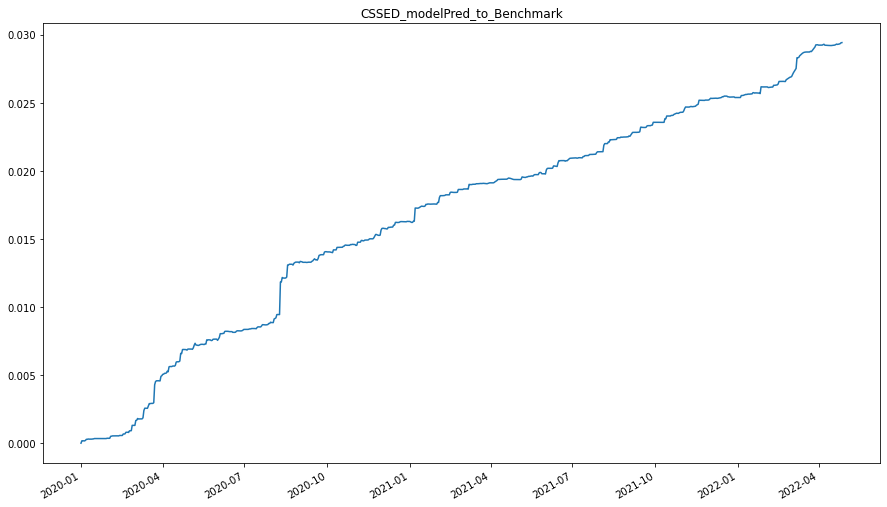

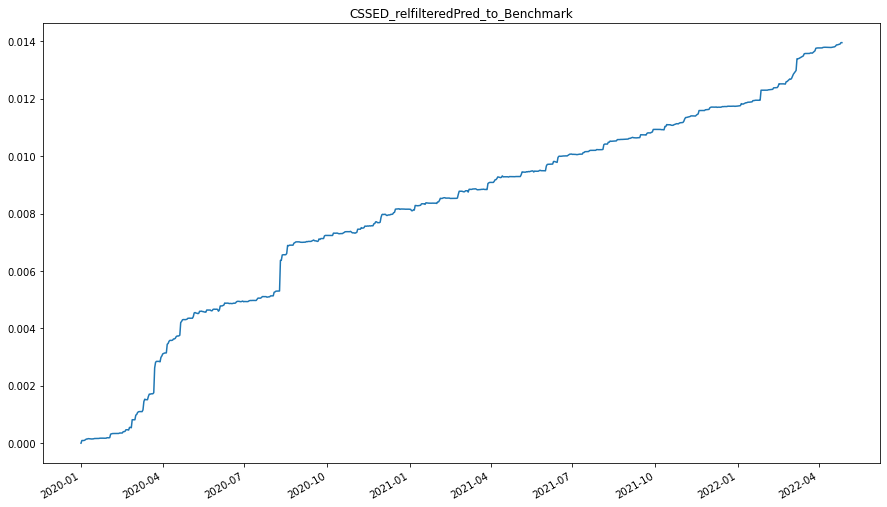

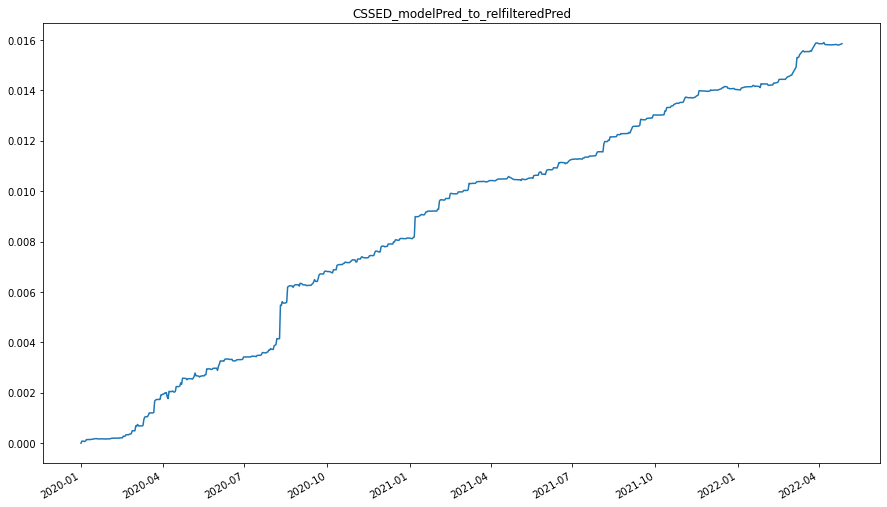

In [4]:
feature_data = pd.read_csv('/mnt/Data/rpan/capstone/data.csv',parse_dates=[0],index_col=0)

roc_cols = [
    'BOL','WOL','COMEX_AU','COMEX_AG','COMEX_CU','DJI','IXIC','SPX','DAX','FTSE','HSI','N225','STI','A50','FCHI','VIX','SC_ETF_VIX','Russell2000_VIX','DJI_VIX','GOLD_ETF_VIX','SPX_VIX','SPX_VIX3M','USDIDX',
    'CRB','CRB_Food','RJCRB_Price_Index','CRB_Indust','CRB_Metal','BCTI_RO_index','BDTI_index','BFGJ_TFindex','BLDH_TFindex','BNM_TFindex','CGH_TFindex','TF_AusQD_BNM','TF_AusQD_HX','TJ_Shippingindex','CDFI_AUSQD','CDFI_BRAQD','CDLB_TFindex','COMEX_AG_Inv',
    'COMEX_AG_mini','COMEX_AU_Inv','COMEX_AU_mini','COMEX_CU_Inv','iShares_ETF_close','iShares_ETF_Hold','LDNAG_SPOT','LDNAU_SPOT','NY_GAS_spot','SPDR_AUETF_Close','SPDR_ETF_Hold','LME_AL_Receipt','LME_AL_Inv','LME_AL_spot',
    'LME_CU_Receipt','LME_CU_Inv','LME_CU_spot','LME_NI_Receipt','LME_NI_Inv','LME_NI_spot','LME_PB_Receipt','LME_PB_Inv','LME_PB_spot','LME_SN_Receipt','LME_SN_Inv','LME_SN_spot','LME_ZN_Receipt','LME_ZN_Inv','LME_ZN_spot'
    ]

diff_cols = [
    'USTSR1Y','USTSR10Y','USTTR5Y','USTTR10Y','LME_CU_STS0to3','LME_NI_STS0to3','LME_PB_STS0to3','LME_SN_STS0to3','LME_ZN_STS0to3','SPX_COMEX_AU','SPX_VIX_Russell2000_VIX_diff',
    'USTSR10Y_USTSR1Y_diff','USTSR10Y_USTTR10Y_diff','COMEX_CU_BOL_logdiff','CRB_CRB_Metal_logdiff','CRB_Indust_CRB_Metal_logdiff','COMEX_AU_BOL_logdiff','COMEX_AU_COMEX_AG_logdiff',
    'COMEX_AU_COMEX_AU_mini_logdiff','LME_CU_Receipt_LME_ZN_Receipt_logdiff'
    ]

stockIndex = ['DJI','IXIC','SPX','DAX','FTSE','HSI','N225','STI','A50','FCHI','VIX','SC_ETF_VIX','Russell2000_VIX','DJI_VIX','GOLD_ETF_VIX','SPX_VIX','SPX_VIX3M']
treasury = ['USTSR1Y','USTSR10Y','USTTR5Y','USTTR10Y','USDIDX']
commPrice = ['BOL','WOL','COMEX_AU','COMEX_AG','COMEX_CU','CRB','CRB_Food','RJCRB_Price_Index','CRB_Indust','CRB_Metal','COMEX_AG_mini','COMEX_AU_mini',]
transportFeeIndex = ['BCTI_RO_index','BDTI_index','BFGJ_TFindex','BLDH_TFindex','BNM_TFindex','CGH_TFindex','TF_AusQD_BNM','TF_AusQD_HX','TJ_Shippingindex','CDFI_AUSQD','CDFI_BRAQD','CDLB_TFindex']
commRefer = ['COMEX_AG_Inv','COMEX_AU_Inv','COMEX_CU_Inv','iShares_ETF_close','iShares_ETF_Hold','LDNAG_SPOT','LDNAU_SPOT','NY_GAS_spot','SPDR_AUETF_Close','SPDR_ETF_Hold','LME_AL_Receipt','LME_AL_Inv','LME_AL_spot',
    'LME_CU_Receipt','LME_CU_Inv','LME_CU_spot','LME_NI_Receipt','LME_NI_Inv','LME_NI_spot','LME_PB_Receipt','LME_PB_Inv','LME_PB_spot','LME_SN_Receipt','LME_SN_Inv','LME_SN_spot','LME_ZN_Receipt','LME_ZN_Inv','LME_ZN_spot',
    'LME_CU_STS0to3','LME_NI_STS0to3','LME_PB_STS0to3','LME_SN_STS0to3','LME_ZN_STS0to3']
complex = ['SPX_COMEX_AU','SPX_VIX_Russell2000_VIX_diff','USTSR10Y_USTSR1Y_diff','USTSR10Y_USTTR10Y_diff','COMEX_CU_BOL_logdiff','CRB_CRB_Metal_logdiff',
        'CRB_Indust_CRB_Metal_logdiff','COMEX_AU_BOL_logdiff','COMEX_AU_COMEX_AG_logdiff','COMEX_AU_COMEX_AU_mini_logdiff','LME_CU_Receipt_LME_ZN_Receipt_logdiff']
categories = [stockIndex,treasury,commPrice,transportFeeIndex,commRefer,complex]

Y_comm = 'COMEX_AU'
feature_data = feature_data.fillna(method='ffill')
feature_data[roc_cols] = feature_data[roc_cols].pct_change().replace([np.inf,-np.inf],np.nan)
feature_data[diff_cols] = feature_data[diff_cols].diff().replace([np.inf,-np.inf],np.nan)
feature_data['Y'] = feature_data[Y_comm].shift(-1)
feature_data = feature_data.dropna()
X = feature_data.iloc[:,:-1]
Y = feature_data['Y']

date_start = pd.to_datetime('2020-01-01')
advance = 3
lookback = 36
window = 126
min_period = 252
normalization=True
fixed=False

pred = walkforward(Y,X,categories,date_start,window,advance,lookback,min_period,normalization,fixed)
print()
print('Proportional reduction of prediction error: ', R2os(pred,Y.loc[date_start:]))

print('----------Calculating Predictions-------------')
relfiltered_pred = pd.concat(Parallel(n_jobs=-1,verbose=0)(delayed(rollingRfilteredPred)(Y,X[cate],window,min_period,normalization,fixed,False) for cate in categories),axis=1).mean(axis=1).loc[date_start:]
print('Proportional reduction of relevance filtered prediction error: ', R2os(relfiltered_pred,Y.loc[date_start:]))

print('----------Calculating BenchMark Predictions-------------')
bm_pred = pd.concat(Parallel(n_jobs=-1,verbose=0)(delayed(rollingPred)(Y,X[cate],window,min_period,normalization,fixed) for cate in categories),axis=1).mean(axis=1).loc[date_start:]
print('Proportional reduction of benchmark prediction error: ', R2os(bm_pred,Y.loc[date_start:]))

CSSED(pred,bm_pred,Y,'modelPred_to_Benchmark')
CSSED(relfiltered_pred,bm_pred,Y,'relfilteredPred_to_Benchmark')
CSSED(pred,relfiltered_pred,Y,'modelPred_to_relfilteredPred')